In [1]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from shapeworld_data import load_raw_data, get_vocab, ShapeWorld

c:\Users\mange\miniconda3\envs\rsa\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly iden

In [2]:
GPT = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ",device)

Device:  cuda


## Prepare data

In [3]:
def check_raw_data(imgs, labels, langs, id=0):
    data = list(zip(imgs,labels,langs))
    img_list,label,lang = data[id]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 2))
    fig.suptitle(" ".join(lang))
    for i,(l,img) in enumerate(zip(label,img_list)):
        img = img.transpose((2,1,0))
        axes[i].imshow(img)
        if l==1: axes[i].set_title("Correct")
    plt.show()

In [4]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")

def sentence2index(sentence):
    tokenized = tokenizer.encode(sentence)
    #print(tokenized)
    return tokenized

In [5]:
root = Path(os.path.abspath('')).parent.parent.absolute()
data_path = os.path.join(root,"data\shapeworld_np")
print(data_path)
data_list = os.listdir(data_path)
print(data_list)

c:\Users\mange\Desktop\Neural-RSA_with_pre-trained-LM\pre-trained_RSA\data\shapeworld_np
['reference-1000-0.npz', 'reference-1000-1.npz', 'reference-1000-2.npz', 'reference-1000-3.npz', 'reference-1000-4.npz']


### Generating vocab_dict

In [6]:
vocab = get_vocab([os.path.join(data_path,d) for d in data_list])
print(vocab["w2i"])

COLOR = {"white":[1,0,0,0,0,0], "green":[0,1,0,0,0,0], "gray":[0,0,1,0,0,0], "yellow":[0,0,0,1,0,0], "red":[0,0,0,0,1,0], "blue":[0,0,0,0,0,1], "other":[0,0,0,0,0,0]}
SHAPE = {"shape":[0,0,0,0], "square":[1,0,0,0], "circle":[0,1,0,0], "rectangle":[0,0,1,0], "ellipse":[0,0,0,1]}

print("Generating Vocab_dict from GPT tokenizer ...")
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
gpt_vocab_dict = tokenizer.get_vocab()
print("Length of the GPT Vocab list is ",len(gpt_vocab_dict.keys()))

PAD = 15636
SOS= EOS = UNK = 50256
original_PAD = 0
original_SOS = 1
original_EOS = 2
original_UNK = 3

w2i = vocab["w2i"]
i2w = vocab["i2w"]

c:\Users\mange\Desktop\Neural-RSA_with_pre-trained-LM\pre-trained_RSA\code\Shapeworld_pragmatic_speaker\shapeworld_data.py:201: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'langs': np.array([t.lower().split() for t in data['langs']])


{'<PAD>': 0, '<sos>': 1, '<eos>': 2, '<UNK>': 3, 'blue': 4, 'shape': 5, 'circle': 6, 'ellipse': 7, 'gray': 8, 'white': 9, 'red': 10, 'rectangle': 11, 'square': 12, 'yellow': 13, 'green': 14}
Generating Vocab_dict from GPT tokenizer ...
Length of the GPT Vocab list is  50257


### Prepapre the data loader

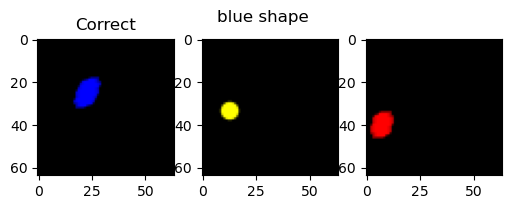

torch.Size([5000, 3, 3, 64, 64]) torch.Size([5000, 3]) torch.Size([5000, 4])
Train, Test data length =  4000 , 1000


In [7]:
d = load_raw_data(os.path.join(data_path,data_list[0]))
imgs = d["imgs"]
labels = d["labels"]
langs = d["langs"]
check_raw_data(d["imgs"],d["labels"],d["langs"])
for i in range(1,5):
    d = load_raw_data(os.path.join(data_path,data_list[i]))
    imgs = np.vstack((imgs,d["imgs"]))
    labels = np.vstack((labels,d["labels"]))
    langs = np.hstack((langs,d["langs"]))
    #check_raw_data(d["imgs"],d["labels"],d["langs"])

imgs_data_tensor = torch.tensor(imgs,dtype=torch.float)
label_data_tensor = torch.tensor(labels)
context_id_data = list(map(sentence2index,langs))
max_context_len = np.max([len(c) for c in context_id_data])
padded_context_data = torch.tensor(np.array([[SOS]+c+[EOS]+[PAD]*(max_context_len-len(c)) for c in context_id_data]))   # <sos>+context+<eos>+<pad>*
print(imgs_data_tensor.shape, label_data_tensor.shape, padded_context_data.shape)

data = [(img,u,l) for img,l,u in zip(imgs_data_tensor,label_data_tensor,padded_context_data)]
test_split = 1000
train_data, test_data = data[:-test_split], data[-test_split:]
print("Train, Test data length = ",len(train_data),",",len(test_data))

train_batch = DataLoader(dataset=train_data,batch_size=32,shuffle=True,num_workers=0)
test_batch = DataLoader(dataset=test_data,batch_size=32,shuffle=False,num_workers=0)

## Model

### Encoder

In [9]:
from literal_listener_shapeworld import CNN_encoder

class Imgs_emb_DeepSet(nn.Module):
    def __init__(self, input_size=10, output_size=20):
        super(Imgs_emb_DeepSet, self).__init__()
        self.linear1 = nn.Linear(input_size, output_size)
        self.linear2 = nn.Linear(input_size, output_size)
        self.linear3 = nn.Linear(output_size, output_size)
    
    def forward(self, img_emb1, img_emb2):
        img_embs = F.relu(self.linear1(img_emb1)) + F.relu(self.linear2(img_emb2))
        img_embs = self.linear3(img_embs)
        return img_embs


class CS_CNN_Encoder(nn.Module):
    def __init__(self, input_size=10, output_size=10):
        super(CS_CNN_Encoder, self).__init__()
        self.cnn_color_encoder = CNN_encoder(6)
        self.cnn_color_encoder.load_state_dict(torch.load("model_params/cnn_color_model_best-loss.pth",map_location=device))
        for params in self.cnn_color_encoder.parameters(): params.requires_grad = False
        self.cnn_shape_encoder = CNN_encoder(4)
        self.cnn_shape_encoder.load_state_dict(torch.load("model_params/cnn_shape_model_best-loss.pth",map_location=device))
        for params in self.cnn_shape_encoder.parameters(): params.requires_grad = False
        self.deepset_size = 6+4
        self.deepset = Imgs_emb_DeepSet(self.deepset_size, self.deepset_size)
        self.linear = nn.Linear(input_size+self.deepset_size, output_size)

    def get_feat_emb(self,feat):
        col_embs = self.cnn_color_encoder(feat)
        shape_embs = self.cnn_shape_encoder(feat)
        img_embs = torch.hstack((col_embs,shape_embs))
        return img_embs
    
    def forward(self,feats,labels):
        idxs = [0,1,2]
        target_idx = int(torch.argmax(labels))
        idxs.remove(target_idx)
        other_idx1,other_idx2 = idxs[0],idxs[1]
        target_img,other_img1,other_img2 = feats[:,target_idx], feats[:,other_idx1], feats[:,other_idx2]
        target_embs = self.get_feat_emb(target_img)
        other_embs1 = self.get_feat_emb(other_img1)
        other_embs2 = self.get_feat_emb(other_img2)                 # (batch_size,10)
        other_embs = F.relu(self.deepset(other_embs1,other_embs2))  # (batch_size,10)
        embs = torch.hstack((target_embs,other_embs))               # (batch_size,20)
        feat = self.linear(embs)                                    # (batch_size,output_size)
        return feat

### Speaker Encoder-Decoder model

In [10]:
# Define the encoder-decoder model
from transformers import EncoderDecoderModel

class S1_EncoderDecoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size=768):
        super(S1_EncoderDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.encoder = CS_CNN_Encoder(input_size, hidden_size)
        self.decoder = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "distilgpt2").decoder

    def forward(self, feats, labels, langs):
        batch_size = len(feats)
        encoder_hidden = self.encoder(feats, labels)
        decoder_hidden = encoder_hidden.reshape(batch_size,1,self.hidden_size)
        decoder_input = langs[:,:-1]
        decoder_output = self.decoder(input_ids=decoder_input, encoder_hidden_states=decoder_hidden)
        return decoder_output[0]
    
    def generate(self,feats,labels,max_len=5,temperature=0.7):
        batch_size = len(feats)
        encoder_hidden = self.encoder(feats, labels)
        decoder_hidden = encoder_hidden.reshape(batch_size,1,self.hidden_size)
        sos = "<|endoftext|>"
        generated = torch.tensor(tokenizer.encode(sos)*batch_size).unsqueeze(1).to(decoder_hidden.device)
        probs_list = torch.zeros(batch_size,50257)
        probs_list[:,SOS] = 1.0
        probs_list = probs_list.unsqueeze(1).to(decoder_hidden.device)
        for i in range(max_len):
            #print(generated.shape)
            decoder_output = self.decoder(input_ids=generated, encoder_hidden_states=decoder_hidden)
            logits = decoder_output[0][:,-1,:]/temperature
            probs = F.softmax(logits,dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            generated = torch.cat((generated, next_token), dim=1)
            probs_list = torch.cat((probs_list,probs.unsqueeze(1)),dim=1)
        return generated,probs_list

## Training

### Setting

In [12]:
import re
def check_data(img_list,c_lang,g_lang,lis_label,cscnn=None,gg_lang=None):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 4))
    context = "Correct: "+" ".join(c_lang)
    if cscnn is not None: context += "\nCSCNN:"+cscnn
    context += "\nGenerated:"+" ".join(g_lang)
    if gg_lang is not None: context += "\n Generated02:"+re.sub(r"<\|endoftext\|>|pad"," ",gg_lang)
    fig.suptitle(context)
    for i,(l,img) in enumerate(zip(label,img_list)):
        img = img.transpose(2,0).to("cpu").detach().numpy()
        axes[i].imshow(img)
        if torch.argmax(lis_label)==i:axes[i].set_title("Listener Prediction")
    plt.show()

In [13]:
from literal_listener_shapeworld import ShapeWorld_RNN_L0, CNN_encoder

feat_dim = 10
speaker = S1_EncoderDecoder(input_size=feat_dim)
speaker.to(device)

# First freeze all the weights
base_model = speaker.decoder.get_output_embeddings()
for param in base_model.parameters():
    param.requires_grad = False
# The release the final one layers out of 6 layers
last_two_layers = speaker.decoder.transformer.h[-1:]
for layer in last_two_layers:
    for param in layer.parameters():
        param.requires_grad = True

literal_listener = ShapeWorld_RNN_L0(len(w2i)).to(device)
literal_listener.load_state_dict(torch.load("model_params\shapeworld_rnn_full-data_100epoch_l0_last.pth",map_location=device))

cnn_color_encoder = CNN_encoder(6).to(device)
cnn_color_encoder.load_state_dict(torch.load("model_params/cnn_color_model_best-loss.pth",map_location=device))
for params in cnn_color_encoder.parameters(): params.requires_grad = False
cnn_shape_encoder = CNN_encoder(4).to(device)
cnn_shape_encoder.load_state_dict(torch.load("model_params/cnn_shape_model_best-loss.pth",map_location=device))
for params in cnn_shape_encoder.parameters(): params.requires_grad = False

optimizer = optim.Adam(speaker.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=PAD)

max_len = 5

epoch = 100

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.0.crossattention.c_

### Start

##############################################
Epoch:1/100


100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


Train Loss:9.14E-01, Test Loss:5.78E-01
Best loss saved ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


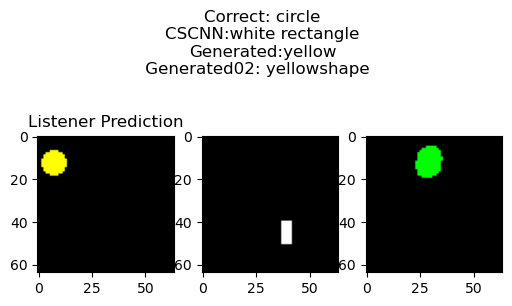

##############################################
Epoch:2/100


100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


Train Loss:5.21E-01, Test Loss:4.54E-01
Best loss saved ...
##############################################
Epoch:3/100


100%|██████████| 32/32 [00:17<00:00,  1.79it/s]


Train Loss:4.77E-01, Test Loss:4.11E-01
Best loss saved ...
##############################################
Epoch:4/100


100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


Train Loss:4.68E-01, Test Loss:4.43E-01
##############################################
Epoch:5/100


100%|██████████| 32/32 [00:17<00:00,  1.79it/s]


Train Loss:4.40E-01, Test Loss:4.01E-01
Best loss saved ...
##############################################
Epoch:6/100


100%|██████████| 32/32 [00:15<00:00,  2.09it/s]


Train Loss:4.34E-01, Test Loss:4.69E-01
##############################################
Epoch:7/100


100%|██████████| 32/32 [00:16<00:00,  1.94it/s]


Train Loss:4.10E-01, Test Loss:3.86E-01
Best loss saved ...
##############################################
Epoch:8/100


100%|██████████| 32/32 [00:17<00:00,  1.82it/s]


Train Loss:3.93E-01, Test Loss:3.93E-01
##############################################
Epoch:9/100


100%|██████████| 32/32 [00:15<00:00,  2.06it/s]


Train Loss:3.85E-01, Test Loss:3.34E-01
Best loss saved ...
##############################################
Epoch:10/100


100%|██████████| 32/32 [00:17<00:00,  1.82it/s]


Train Loss:3.86E-01, Test Loss:3.41E-01
##############################################
Epoch:11/100


100%|██████████| 32/32 [00:17<00:00,  1.83it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Loss:3.76E-01, Test Loss:3.56E-01


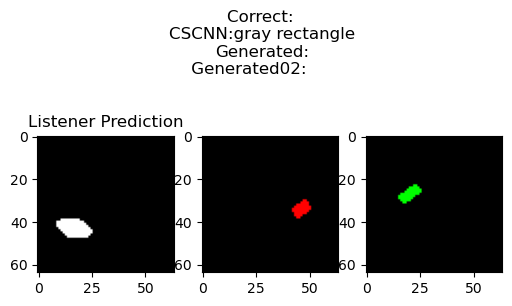

##############################################
Epoch:12/100


100%|██████████| 32/32 [00:17<00:00,  1.78it/s]


Train Loss:3.67E-01, Test Loss:3.40E-01
##############################################
Epoch:13/100


100%|██████████| 32/32 [00:15<00:00,  2.07it/s]


Train Loss:3.66E-01, Test Loss:3.44E-01
##############################################
Epoch:14/100


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


Train Loss:3.73E-01, Test Loss:3.39E-01
##############################################
Epoch:15/100


100%|██████████| 32/32 [00:17<00:00,  1.85it/s]


Train Loss:3.64E-01, Test Loss:3.37E-01
##############################################
Epoch:16/100


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


Train Loss:3.61E-01, Test Loss:3.06E-01
Best loss saved ...
##############################################
Epoch:17/100


100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Train Loss:3.54E-01, Test Loss:3.24E-01
##############################################
Epoch:18/100


100%|██████████| 32/32 [00:17<00:00,  1.83it/s]


Train Loss:3.61E-01, Test Loss:3.26E-01
##############################################
Epoch:19/100


100%|██████████| 32/32 [00:16<00:00,  1.96it/s]


Train Loss:3.44E-01, Test Loss:3.35E-01
##############################################
Epoch:20/100


100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Train Loss:3.57E-01, Test Loss:3.28E-01
##############################################
Epoch:21/100


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Loss:3.59E-01, Test Loss:3.22E-01


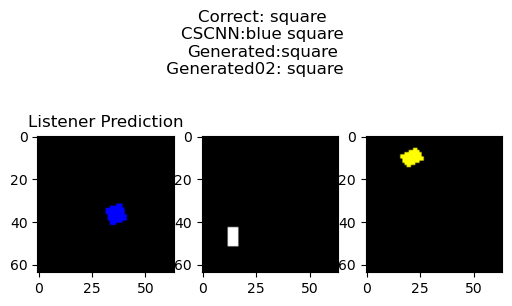

##############################################
Epoch:22/100


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


Train Loss:3.57E-01, Test Loss:3.40E-01
##############################################
Epoch:23/100


100%|██████████| 32/32 [00:17<00:00,  1.85it/s]


Train Loss:3.44E-01, Test Loss:3.15E-01
##############################################
Epoch:24/100


100%|██████████| 32/32 [00:17<00:00,  1.88it/s]


Train Loss:3.45E-01, Test Loss:3.45E-01
##############################################
Epoch:25/100


100%|██████████| 32/32 [00:17<00:00,  1.81it/s]


Train Loss:3.59E-01, Test Loss:3.18E-01
##############################################
Epoch:26/100


100%|██████████| 32/32 [00:17<00:00,  1.81it/s]


Train Loss:3.41E-01, Test Loss:3.22E-01
##############################################
Epoch:27/100


100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


Train Loss:3.51E-01, Test Loss:3.44E-01
##############################################
Epoch:28/100


100%|██████████| 32/32 [00:13<00:00,  2.40it/s]


Train Loss:3.42E-01, Test Loss:3.15E-01
##############################################
Epoch:29/100


100%|██████████| 32/32 [00:15<00:00,  2.07it/s]


Train Loss:3.42E-01, Test Loss:3.25E-01
##############################################
Epoch:30/100


100%|██████████| 32/32 [00:16<00:00,  1.89it/s]


Train Loss:3.31E-01, Test Loss:3.36E-01
##############################################
Epoch:31/100


100%|██████████| 32/32 [00:16<00:00,  1.91it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Loss:3.28E-01, Test Loss:3.15E-01


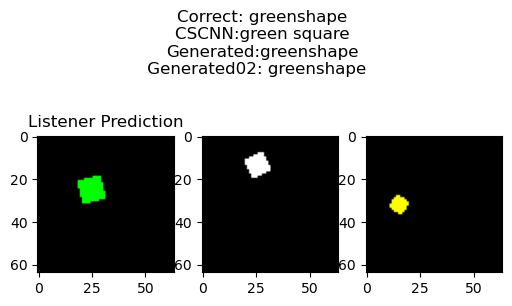

##############################################
Epoch:32/100


100%|██████████| 32/32 [00:15<00:00,  2.08it/s]


Train Loss:3.37E-01, Test Loss:3.30E-01
##############################################
Epoch:33/100


100%|██████████| 32/32 [00:15<00:00,  2.09it/s]


Train Loss:3.40E-01, Test Loss:3.28E-01
##############################################
Epoch:34/100


100%|██████████| 32/32 [00:16<00:00,  1.89it/s]


Train Loss:3.46E-01, Test Loss:3.31E-01
##############################################
Epoch:35/100


100%|██████████| 32/32 [00:17<00:00,  1.81it/s]


Train Loss:3.36E-01, Test Loss:3.12E-01
##############################################
Epoch:36/100


100%|██████████| 32/32 [00:17<00:00,  1.82it/s]


Train Loss:3.27E-01, Test Loss:3.40E-01
##############################################
Epoch:37/100


100%|██████████| 32/32 [00:17<00:00,  1.81it/s]


Train Loss:3.31E-01, Test Loss:3.41E-01
##############################################
Epoch:38/100


100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Train Loss:3.39E-01, Test Loss:3.10E-01
##############################################
Epoch:39/100


100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Train Loss:3.43E-01, Test Loss:3.14E-01
##############################################
Epoch:40/100


100%|██████████| 32/32 [00:17<00:00,  1.82it/s]


Train Loss:3.34E-01, Test Loss:3.01E-01
Best loss saved ...
##############################################
Epoch:41/100


100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Train Loss:3.26E-01, Test Loss:3.73E-01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


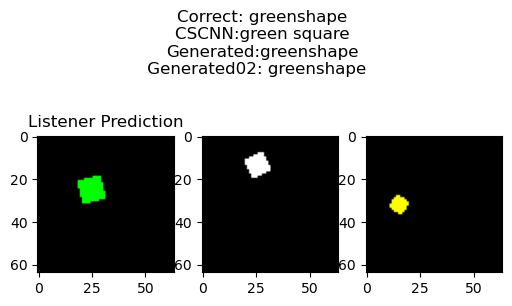

##############################################
Epoch:42/100


100%|██████████| 32/32 [00:14<00:00,  2.22it/s]


Train Loss:3.33E-01, Test Loss:3.01E-01
##############################################
Epoch:43/100


100%|██████████| 32/32 [00:14<00:00,  2.21it/s]


Train Loss:3.34E-01, Test Loss:3.18E-01
##############################################
Epoch:44/100


100%|██████████| 32/32 [00:17<00:00,  1.85it/s]


Train Loss:3.20E-01, Test Loss:3.51E-01
##############################################
Epoch:45/100


100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


Train Loss:3.30E-01, Test Loss:3.20E-01
##############################################
Epoch:46/100


100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


Train Loss:3.21E-01, Test Loss:3.23E-01
##############################################
Epoch:47/100


100%|██████████| 32/32 [00:15<00:00,  2.06it/s]


Train Loss:3.16E-01, Test Loss:3.17E-01
##############################################
Epoch:48/100


100%|██████████| 32/32 [00:16<00:00,  1.96it/s]


Train Loss:3.11E-01, Test Loss:3.33E-01
##############################################
Epoch:49/100


100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


Train Loss:3.17E-01, Test Loss:3.17E-01
##############################################
Epoch:50/100


100%|██████████| 32/32 [00:15<00:00,  2.09it/s]


Train Loss:3.22E-01, Test Loss:3.14E-01
##############################################
Epoch:51/100


100%|██████████| 32/32 [00:14<00:00,  2.22it/s]


Train Loss:3.21E-01, Test Loss:2.96E-01
Best loss saved ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


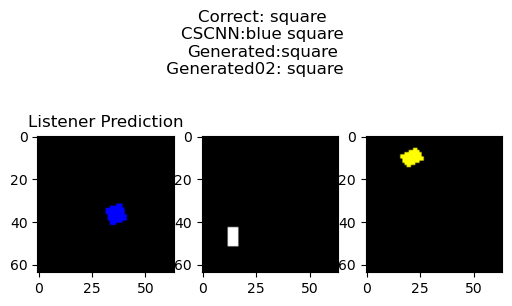

##############################################
Epoch:52/100


100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


Train Loss:2.97E-01, Test Loss:2.98E-01
##############################################
Epoch:53/100


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


Train Loss:3.00E-01, Test Loss:3.29E-01
##############################################
Epoch:54/100


100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Train Loss:3.02E-01, Test Loss:3.22E-01
##############################################
Epoch:55/100


100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


Train Loss:3.06E-01, Test Loss:3.16E-01
##############################################
Epoch:56/100


100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Train Loss:3.08E-01, Test Loss:3.10E-01
##############################################
Epoch:57/100


100%|██████████| 32/32 [00:13<00:00,  2.40it/s]


Train Loss:3.08E-01, Test Loss:3.07E-01
##############################################
Epoch:58/100


100%|██████████| 32/32 [00:17<00:00,  1.83it/s]


Train Loss:2.94E-01, Test Loss:3.19E-01
##############################################
Epoch:59/100


100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


Train Loss:3.02E-01, Test Loss:3.26E-01
##############################################
Epoch:60/100


100%|██████████| 32/32 [00:15<00:00,  2.09it/s]


Train Loss:3.08E-01, Test Loss:3.09E-01
##############################################
Epoch:61/100


100%|██████████| 32/32 [00:16<00:00,  1.91it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Loss:3.02E-01, Test Loss:3.09E-01


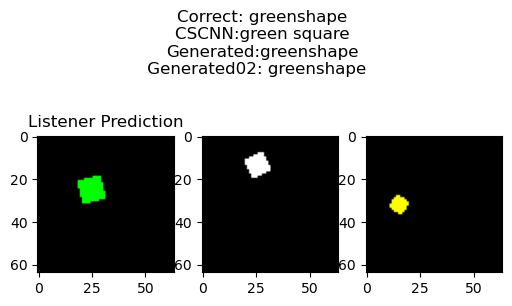

##############################################
Epoch:62/100


100%|██████████| 32/32 [00:15<00:00,  2.08it/s]


Train Loss:2.89E-01, Test Loss:3.09E-01
##############################################
Epoch:63/100


100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


Train Loss:2.91E-01, Test Loss:3.07E-01
##############################################
Epoch:64/100


100%|██████████| 32/32 [00:17<00:00,  1.83it/s]


Train Loss:2.98E-01, Test Loss:2.83E-01
Best loss saved ...
##############################################
Epoch:65/100


100%|██████████| 32/32 [00:15<00:00,  2.12it/s]


Train Loss:3.01E-01, Test Loss:3.14E-01
##############################################
Epoch:66/100


100%|██████████| 32/32 [00:15<00:00,  2.06it/s]


Train Loss:2.86E-01, Test Loss:3.37E-01
##############################################
Epoch:67/100


100%|██████████| 32/32 [00:17<00:00,  1.88it/s]


Train Loss:2.89E-01, Test Loss:3.20E-01
##############################################
Epoch:68/100


100%|██████████| 32/32 [00:17<00:00,  1.88it/s]


Train Loss:2.94E-01, Test Loss:3.04E-01
##############################################
Epoch:69/100


100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


Train Loss:2.91E-01, Test Loss:3.11E-01
##############################################
Epoch:70/100


100%|██████████| 32/32 [00:15<00:00,  2.13it/s]


Train Loss:2.78E-01, Test Loss:3.18E-01
##############################################
Epoch:71/100


100%|██████████| 32/32 [00:14<00:00,  2.21it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Loss:2.83E-01, Test Loss:3.03E-01


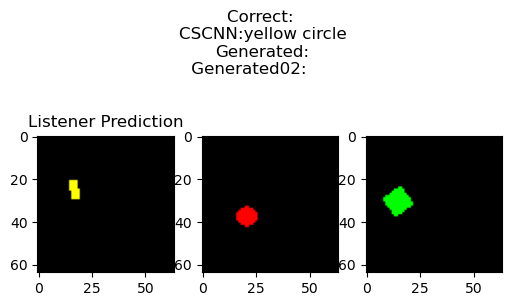

##############################################
Epoch:72/100


100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


Train Loss:2.95E-01, Test Loss:3.29E-01
##############################################
Epoch:73/100


100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Train Loss:2.93E-01, Test Loss:3.07E-01
##############################################
Epoch:74/100


100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


Train Loss:2.80E-01, Test Loss:3.04E-01
##############################################
Epoch:75/100


100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Train Loss:2.75E-01, Test Loss:3.01E-01
##############################################
Epoch:76/100


100%|██████████| 32/32 [00:17<00:00,  1.82it/s]


Train Loss:2.72E-01, Test Loss:3.14E-01
##############################################
Epoch:77/100


100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


Train Loss:2.78E-01, Test Loss:3.06E-01
##############################################
Epoch:78/100


100%|██████████| 32/32 [00:15<00:00,  2.10it/s]


Train Loss:2.80E-01, Test Loss:2.97E-01
##############################################
Epoch:79/100


100%|██████████| 32/32 [00:17<00:00,  1.85it/s]


Train Loss:2.67E-01, Test Loss:3.01E-01
##############################################
Epoch:80/100


100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


Train Loss:2.89E-01, Test Loss:3.03E-01
##############################################
Epoch:81/100


100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Loss:2.74E-01, Test Loss:3.04E-01


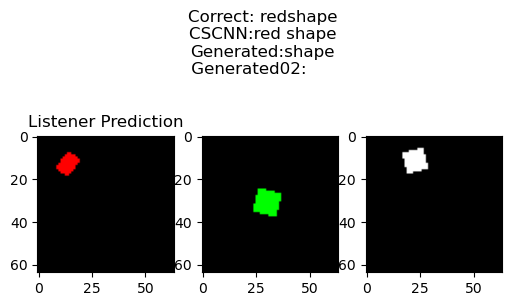

##############################################
Epoch:82/100


100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


Train Loss:2.78E-01, Test Loss:3.12E-01
##############################################
Epoch:83/100


100%|██████████| 32/32 [00:14<00:00,  2.14it/s]


Train Loss:2.79E-01, Test Loss:2.93E-01
##############################################
Epoch:84/100


100%|██████████| 32/32 [00:17<00:00,  1.85it/s]


Train Loss:2.60E-01, Test Loss:2.99E-01
##############################################
Epoch:85/100


100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


Train Loss:2.59E-01, Test Loss:2.90E-01
##############################################
Epoch:86/100


100%|██████████| 32/32 [00:17<00:00,  1.86it/s]


Train Loss:2.77E-01, Test Loss:2.96E-01
##############################################
Epoch:87/100


100%|██████████| 32/32 [00:10<00:00,  3.06it/s]


Train Loss:2.65E-01, Test Loss:3.20E-01
##############################################
Epoch:88/100


100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


Train Loss:2.61E-01, Test Loss:3.27E-01
##############################################
Epoch:89/100


100%|██████████| 32/32 [00:15<00:00,  2.07it/s]


Train Loss:2.68E-01, Test Loss:3.19E-01
##############################################
Epoch:90/100


100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


Train Loss:2.59E-01, Test Loss:2.92E-01
##############################################
Epoch:91/100


100%|██████████| 32/32 [00:15<00:00,  2.01it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Loss:2.56E-01, Test Loss:2.99E-01


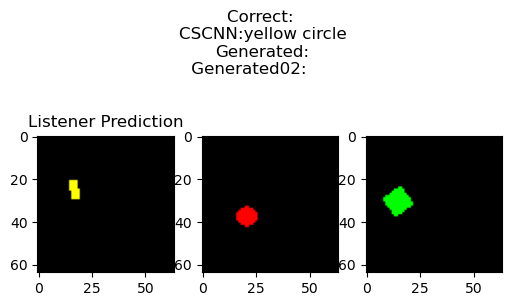

##############################################
Epoch:92/100


100%|██████████| 32/32 [00:19<00:00,  1.67it/s]


Train Loss:2.61E-01, Test Loss:3.09E-01
##############################################
Epoch:93/100


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Train Loss:2.56E-01, Test Loss:2.85E-01
##############################################
Epoch:94/100


100%|██████████| 32/32 [00:06<00:00,  4.58it/s]


Train Loss:2.59E-01, Test Loss:3.02E-01
##############################################
Epoch:95/100


100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


Train Loss:2.50E-01, Test Loss:3.13E-01
##############################################
Epoch:96/100


100%|██████████| 32/32 [00:07<00:00,  4.28it/s]


Train Loss:2.56E-01, Test Loss:3.13E-01
##############################################
Epoch:97/100


100%|██████████| 32/32 [00:07<00:00,  4.33it/s]


Train Loss:2.55E-01, Test Loss:3.29E-01
##############################################
Epoch:98/100


100%|██████████| 32/32 [00:07<00:00,  4.35it/s]


Train Loss:2.51E-01, Test Loss:2.98E-01
##############################################
Epoch:99/100


100%|██████████| 32/32 [00:07<00:00,  4.30it/s]


Train Loss:2.56E-01, Test Loss:3.22E-01
##############################################
Epoch:100/100


100%|██████████| 32/32 [00:07<00:00,  4.26it/s]


Train Loss:2.55E-01, Test Loss:3.01E-01


In [14]:
from tqdm import tqdm

train_loss_list = []
test_loss_list = []
best_loss = 100
for i in range(epoch):
    print("##############################################")
    print("Epoch:{}/{}".format(i+1,epoch))
    train_loss = 0
    test_loss = 0

    speaker.train()
    for cols,lang,label in tqdm(train_batch):
        cols, lang, label = cols.to(device), lang.type(torch.LongTensor).to(device), label.to(device)
        optimizer.zero_grad()
        output = speaker(cols, label, lang)
        # Compute the loss
        output_view = output.view(-1, output.shape[-1])
        target = lang[:,1:].reshape(-1)
        lang_loss = criterion(output_view, target)
        lang_loss.backward(retain_graph=True)
        optimizer.step()
        train_loss += lang_loss.item()
        #break
    batch_train_loss = train_loss/len(train_batch)

    accs = []
    speaker.eval()
    with torch.no_grad():
        for cols,lang,label in tqdm(test_batch):
            cols, lang, label = cols.to(device), lang.type(torch.LongTensor).to(device), label.to(device)
            output = speaker(cols, label, lang)
            target_col, target_shape = cnn_color_encoder(cols[:,0]), cnn_shape_encoder(cols[:,0])
            target_cols = [list(COLOR.keys())[int(torch.argmax(col_vec))] for col_vec in target_col]
            target_shapes = [list(SHAPE.keys())[int(torch.argmax(shape_vec))] for shape_vec in target_shape]
            direct_target_utter = [c+" "+s for c,s in zip(target_cols,target_shapes)]
            output_view = output.view(-1, output.shape[-1])
            target = lang[:,1:].reshape(-1)
            lang_loss = criterion(output_view, target)
            test_loss += lang_loss.item()
            generated,lang_probs = speaker.generate(cols,label,max_len=max_len)
            #break
        batch_test_loss = test_loss/len(test_batch)

    print("Train Loss:{:.2E}, Test Loss:{:.2E}".format(batch_train_loss,batch_test_loss))
    train_loss_list.append(batch_train_loss)
    test_loss_list.append(batch_test_loss)
    if batch_test_loss < best_loss:
        print("Best loss saved ...")
        torch.save(speaker.to(device).state_dict(),"model_params/shapeworld_S1-GPT2-decoder_loss=Lang_best-loss_freeze-1_100epoch.pth")
        best_loss = batch_test_loss
    if i%10 == 0:
        id = np.random.randint(len(cols))
        cols = cols[id].to("cpu")
        c_langs = tokenizer.decode([idx for idx in lang[id].to("cpu").tolist() if idx not in [PAD,SOS,EOS]]).split(" ")
        g_langs = tokenizer.decode([idx for idx in output.argmax(2)[id].to("cpu").tolist() if idx not in [PAD,SOS,EOS]]).split(" ")
        lis_label = torch.zeros(3)
        lis_label[0] = 1.0
        check_data(cols, c_langs, g_langs, lis_label, cscnn=direct_target_utter[id],gg_lang=tokenizer.decode(generated[id]))
    #break

## Accuracy

In [25]:
from tqdm import tqdm
from literal_listener_shapeworld import ShapeWorld_RNN_L0, CNN_encoder

feat_dim = 10
speaker = S1_EncoderDecoder(input_size=feat_dim).to(device)
best = "model_params/shapeworld_S1-GPT2-decoder_loss=Lang_best-loss_freeze-1_100epoch.pth"
speaker.load_state_dict(torch.load(best,map_location=device))
speaker.to(device)

literal_listener = ShapeWorld_RNN_L0(len(w2i)).to(device)
literal_listener.load_state_dict(torch.load("model_params\shapeworld_rnn_full-data_100epoch_l0_last.pth",map_location=device))

print("Model loaded ...")

optimizer = optim.Adam(speaker.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

max_len = 5


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.0.crossattention.c_

Model loaded ...


c:\Users\mange\miniconda3\envs\rsa\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


### L0 accuracy

In [26]:
col_list = list(COLOR.keys())
col_list[-1] = ""
shape_list = list(SHAPE.keys())
utter_list = [" ".join([w for w in (c+" "+s).split(" ") if w]) for c in col_list for s in shape_list+[""]]
gpt_utter_list = ["".join([w for w in (c+" "+s).split(" ") if w]) for c in col_list for s in shape_list+[""]]
vocab2gpt = {g:u for u,g in zip(utter_list,gpt_utter_list)}
for g,u in vocab2gpt.items():
    print(u," : ",g)

white shape  :  whiteshape
white square  :  whitesquare
white circle  :  whitecircle
white rectangle  :  whiterectangle
white ellipse  :  whiteellipse
white  :  white
green shape  :  greenshape
green square  :  greensquare
green circle  :  greencircle
green rectangle  :  greenrectangle
green ellipse  :  greenellipse
green  :  green
gray shape  :  grayshape
gray square  :  graysquare
gray circle  :  graycircle
gray rectangle  :  grayrectangle
gray ellipse  :  grayellipse
gray  :  gray
yellow shape  :  yellowshape
yellow square  :  yellowsquare
yellow circle  :  yellowcircle
yellow rectangle  :  yellowrectangle
yellow ellipse  :  yellowellipse
yellow  :  yellow
red shape  :  redshape
red square  :  redsquare
red circle  :  redcircle
red rectangle  :  redrectangle
red ellipse  :  redellipse
red  :  red
blue shape  :  blueshape
blue square  :  bluesquare
blue circle  :  bluecircle
blue rectangle  :  bluerectangle
blue ellipse  :  blueellipse
blue  :  blue
shape  :  shape
square  :  square


In [27]:
from nltk.tokenize import word_tokenize
from functools import reduce

def decode_gpt_vocab(w):
    if w in w2i.keys(): 
        return [w2i[w]]
    elif w in vocab2gpt.keys():
        return [w2i[t] for t in vocab2gpt[w].split(" ")]
    else:
        return [original_UNK]

def gpt_lang2L0_lang(generated_langs):
    langs = [tokenizer.decode([idx for idx in generated if idx not in [PAD,SOS,EOS]]) for generated in generated_langs]
    tokens = []
    for l in langs:
        decoded = [decode_gpt_vocab(w) for w in word_tokenize(l)]+[[],[]]
        tokens.append(list(reduce(lambda x,y:x+y,decoded)))
    max_tokens_len = max([len(t) for t in tokens])
    padded_tokens = torch.tensor(np.array([[original_SOS]+ts+[original_EOS]+[original_PAD]*(max_tokens_len-len(ts)) for ts in tokens]))
    return padded_tokens

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 / 32
['<sos>', 'circle', '<eos>', '<PAD>']


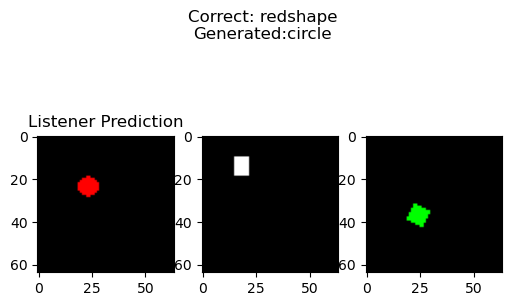

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11 / 32
['<sos>', '<eos>', '<PAD>', '<PAD>']


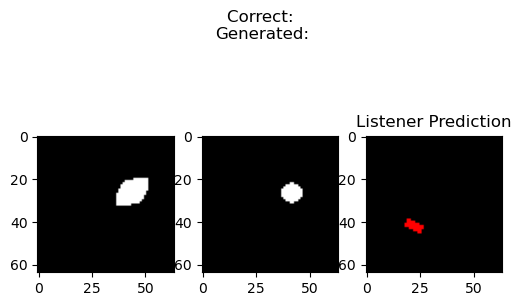

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21 / 32
['<sos>', '<eos>', '<PAD>', '<PAD>']


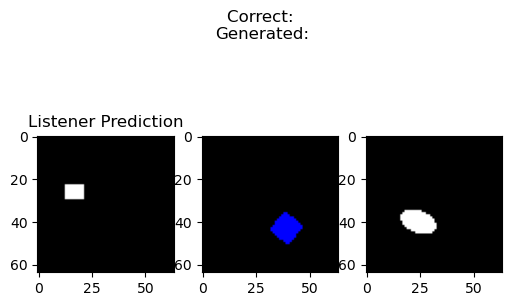

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31 / 32
['<sos>', 'gray', 'shape', '<eos>']


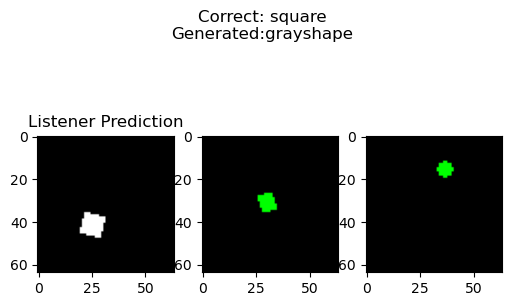

Accuracy:  0.6220703125


In [28]:
accs = []
speaker.eval()
#speaker = speaker.cpu()
with torch.no_grad():
    for i,(cols,lang,label) in enumerate(test_batch):
        cols, lang, label = cols.to(device), lang.to(device), label.to(device)
        generated_lang, lang_probs = speaker.generate(cols,label,max_len=max_len)
        output_lang = gpt_lang2L0_lang(generated_lang).to(device)
        literal_listener.eval()
        #literal_listener = literal_listener.cpu()
        lis_labels = literal_listener(cols, output_lang)
        pred_labels = torch.argmax(lis_labels,dim=1)
        correct_labels = torch.zeros(cols.shape[0])
        acc = sum(correct_labels.to(device)==pred_labels)/len(correct_labels)
        accs.append(acc.item())
        if i%10 == 0:
            print(i+1,"/",len(test_batch))
            id = np.random.randint(len(cols))
            cols = cols[id].to("cpu")
            print([i2w[int(idx)] for idx in output_lang[id]])
            c_langs = tokenizer.decode([idx for idx in lang[id].to("cpu").tolist() if idx not in [PAD,SOS,EOS]]).split(" ")
            g_langs = tokenizer.decode([idx for idx in generated_lang[id].to("cpu").tolist() if idx not in [PAD,SOS,EOS]]).split(" ")
            label = label[id]
            #print(int(torch.argmax(lis_labels[id])))
            check_data(cols, c_langs, g_langs, lis_labels[id])

print("Accuracy: ",np.mean(accs))

### L1 accuracy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


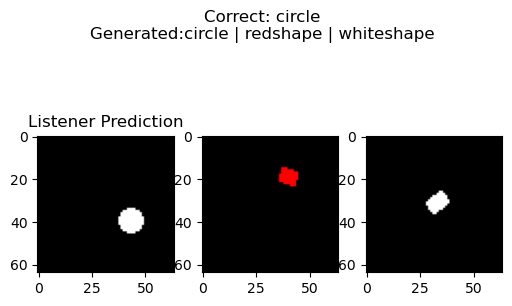

tensor([2.7174, 1.0000, 1.0003])
tensor([1, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


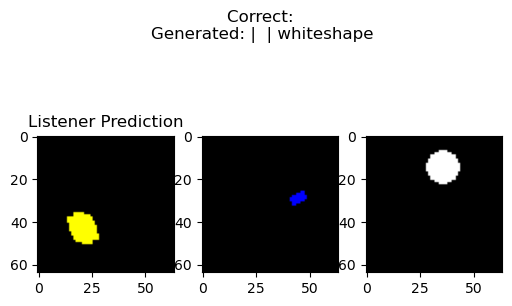

tensor([1.7802, 1.5270, 1.0000])
tensor([1, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


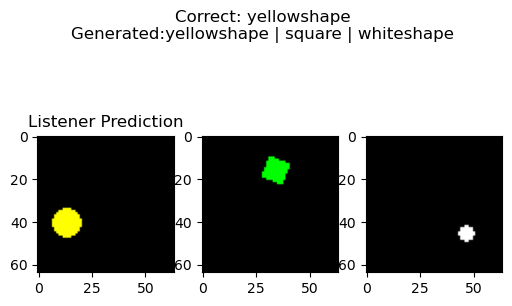

tensor([2.7154, 1.0000, 1.0011])
tensor([1, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


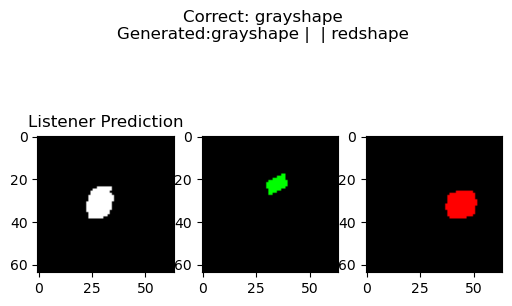

tensor([2.7156, 1.0000, 1.0010])
tensor([1, 1, 1])
Loss:  0.7127579133957624
Accuracy:  0.814453125


In [29]:
losss = []
accs = []
speaker.eval()

for i,(cols,lang,label) in enumerate(test_batch):
    cols, lang, label = cols.to(device).to(torch.float), lang.to(device), label.to(device).to(torch.float)
    # for 1st image
    label01 = torch.zeros_like(label)
    label01[:,0] = 1.0
    generated_lang1, lang_probs1 = speaker.generate(cols,label01,max_len=max_len)
    # for 2nd image
    label02 = torch.zeros_like(label)
    label02[:,1] = 1.0
    generated_lang2, lang_probs2 = speaker.generate(cols,label02,max_len=max_len)
    # for 3rd image
    label03 = torch.zeros_like(label)
    label03[:,2] = 1.0
    generated_lang3, lang_probs3 = speaker.generate(cols,label03,max_len=max_len)
    
    # compute the probability
    prob01 = [[torch.log(word_dist[idx]+0.001).to("cpu").detach() for word_dist,idx in zip(sent,idxs)] \
              for batch,(sent,idxs) in enumerate(zip(lang_probs1,lang))]
    prob01_sums = list(map(sum,prob01))
    prob02 = [[torch.log(word_dist[idx]+0.001).to("cpu").detach() for word_dist,idx in zip(sent,idxs)] \
              for batch,(sent,idxs) in enumerate(zip(lang_probs2,lang))]
    prob02_sums = list(map(sum,prob02))
    prob03 = [[torch.log(word_dist[idx]+0.001).to("cpu").detach() for word_dist,idx in zip(sent,idxs)] \
              for batch,(sent,idxs) in enumerate(zip(lang_probs3,lang))]
    prob03_sums = list(map(sum,prob03))
    probs = F.softmax(torch.tensor(np.array([prob01_sums,prob02_sums,prob03_sums])).transpose(0,1),dim=-1)
    #print(probs)
    loss = criterion(probs.to(device),label)
    losss.append(loss.item())
    pred_labels = torch.argmax(probs,dim=1)
    correct_labels = torch.zeros(cols.shape[0])
    acc = sum(correct_labels==pred_labels)/len(correct_labels)
    accs.append(acc.item())
    
    if i%10 == 0:
        id = np.random.randint(len(cols))
        imgs = cols[id].to("cpu")
        c_langs = tokenizer.decode([idx for idx in lang[id].to("cpu").tolist() if idx not in [PAD,SOS,EOS]]).split(" ")
        g_langs = tokenizer.decode([idx for idx in generated_lang1[id].to("cpu").tolist() if idx not in [PAD,SOS,EOS]]).split(" ")\
                + ["|"]+ tokenizer.decode([idx for idx in generated_lang2[id].to("cpu").tolist() if idx not in [PAD,SOS,EOS]]).split(" ") \
                + ["|"]+ tokenizer.decode([idx for idx in generated_lang3[id].to("cpu").tolist() if idx not in [PAD,SOS,EOS]]).split(" ")
        label = label[id]
        check_data(imgs, c_langs, g_langs, probs[id])
        print(torch.exp(probs[id]))
        print(torch.where(torch.exp(probs[id])>0.1,1,0))

print("Loss: ",np.mean(losss))
print("Accuracy: ",np.mean(accs))